# Modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Masking, Dropout
import keras
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from keras import Model
import random
import math
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

random.seed(1) # for consistency of results 

## Formatting Data for Model 

In [2]:
# Load data from preprocessing 
formatted_data = pd.read_csv("Formatted_Data.csv")
formatted_data.head()

,new_id,day,date,Anxious.morning,Anxious.afternoon,Anxious.night,gad7_total,month_start_date,month_end_date
0,1001_0,0,2016-05-11,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
1,1001_0,1,2016-05-12,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
2,1001_0,2,2016-05-13,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
3,1001_0,3,2016-05-14,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
4,1001_0,4,2016-05-15,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07


In [3]:
# Find number of days per person-month 
measured_days = []
for individual in sorted(list(set(formatted_data['new_id']))):
    person_data = formatted_data[formatted_data['new_id']==individual]
    measured_days.append(len(person_data))
total_timepoints = min(measured_days)
total_timepoints

28

In [4]:
# Scale anxiety features
total_array = []
for individual in sorted(list(set(formatted_data['new_id']))):
    person_array = []
    person_data = formatted_data[formatted_data['new_id']==individual]
    for time_point in range(total_timepoints):
        time_array = list(person_data[['Anxious.morning', 'Anxious.afternoon', 'Anxious.night']].iloc[time_point,:])
        time_array = [(data-1)/6.0 for data in time_array]
        person_array.append(time_array)
    total_array.append(person_array)

In [5]:
# All data: (236 person-months) x (28 days per person-month) x (3 measurements per day)
formatted_data=np.array(total_array)
formatted_data.shape

(236, 28, 3)

In [6]:
# Convert nan's in data to -1 to be suitable for model 
formatted_data_removed_nans = np.nan_to_num(formatted_data, nan=-1)
formatted_data_removed_nans

array([[[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]],

       [[-1.        ,  0.33333333,  0.        ],
        [ 0.5       ,  0.33333333,  0.        ],
        [ 0.83333333,  0.5       ,  0.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]],

       [[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [7]:
# Only include data if less than 70% of anxiety measurements are missing
# I.E. each person-month needs at least 26/84 anxiety measurements to be passed into model
def over_70_percent_nan(person_data):
    nas = 0 
    for time in person_data:
        for feat in range(3):
            if time[feat] == -1: 
                nas += 1 
    return nas > 58 
    
data_filtered_nans = [person_data for person_data in formatted_data_removed_nans if not over_70_percent_nan(person_data)]
formatted_data_filtered_nans = np.array(data_filtered_nans)

In [8]:
# Filtered data: (66 person-months) x (28 days per person-month) x (3 measurements per day)
formatted_data_filtered_nans.shape

(66, 28, 3)

In [9]:
# Find missingness of data after filtering
# Find number of anxiety measurements after filtering
total_nas = 0 
all_nas = [] 
for person in formatted_data_filtered_nans:
    nas = 0
    for time in person:
        for feat in range(3):
            if time[feat] == -1:
                nas+=1
    total_nas += nas 
    all_nas.append(nas/(28*3))
print("Mean proportion of missingness in filtered data : " + str(np.mean(all_nas)))
print("Total data points : " + str(len(all_nas)*84 - total_nas))

Mean proportion of missingness in filtered data : 0.48737373737373735
Total data points : 2842


## Training Model 

In [10]:
# Create Training and Validation Set 
x_placeholder = list(range(66))
x_train, x_test, train, test = train_test_split(x_placeholder, formatted_data_filtered_nans, train_size= 46, test_size= 20, random_state=1)

In [11]:
# Build and train LSTM model 
model1 = Sequential()
model1.add(LSTM(64, activation='elu', input_shape=(total_timepoints,formatted_data_filtered_nans.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='elu', return_sequences=True))
model1.add(LSTM(3, activation='elu', return_sequences=True))
model1.add(LSTM(3, activation='elu', return_sequences=True))
model1.add(LSTM(32, activation='elu', return_sequences=True))
model1.add(LSTM(64, activation='elu', return_sequences=True))
model1.add(TimeDistributed(Dense(formatted_data_filtered_nans.shape[2])))
model1.compile(optimizer='adam', loss='mae')

# Check-Point to save model weights and cost history 
filepath = "weights-improvement-test-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

model1.fit(train, train, validation_data=(test,test),epochs=1500, verbose=1, callbacks=callbacks_list)

Epoch 1/1500
2/2 [==============================] - 5s 1s/step - loss: 0.6523 - val_loss: 0.6207

Epoch 00001: saving model to weights-improvement-test-01.hdf5
Epoch 2/1500
2/2 [==============================] - 0s 102ms/step - loss: 0.6577 - val_loss: 0.6199

Epoch 00002: saving model to weights-improvement-test-02.hdf5
Epoch 3/1500
2/2 [==============================] - 0s 90ms/step - loss: 0.6574 - val_loss: 0.6180

Epoch 00003: saving model to weights-improvement-test-03.hdf5
Epoch 4/1500
2/2 [==============================] - 0s 94ms/step - loss: 0.6546 - val_loss: 0.6142

Epoch 00004: saving model to weights-improvement-test-04.hdf5
Epoch 5/1500
2/2 [==============================] - 0s 89ms/step - loss: 0.6494 - val_loss: 0.6066

Epoch 00005: saving model to weights-improvement-test-05.hdf5
Epoch 6/1500
2/2 [==============================] - 0s 81ms/step - loss: 0.6411 - val_loss: 0.5914

Epoch 00006: saving model to weights-improvement-test-06.hdf5
Epoch 7/1500
2/2 [===========

2/2 [==============================] - 0s 72ms/step - loss: 0.5044 - val_loss: 0.4363

Epoch 00051: saving model to weights-improvement-test-51.hdf5
Epoch 52/1500
2/2 [==============================] - 0s 167ms/step - loss: 0.4952 - val_loss: 0.4394

Epoch 00052: saving model to weights-improvement-test-52.hdf5
Epoch 53/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.5013 - val_loss: 0.4353

Epoch 00053: saving model to weights-improvement-test-53.hdf5
Epoch 54/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4935 - val_loss: 0.4348

Epoch 00054: saving model to weights-improvement-test-54.hdf5
Epoch 55/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4984 - val_loss: 0.4357

Epoch 00055: saving model to weights-improvement-test-55.hdf5
Epoch 56/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.5016 - val_loss: 0.4325

Epoch 00056: saving model to weights-improvement-test-56.hdf5
Epoch 57/1500
2/2 [================

2/2 [==============================] - 0s 71ms/step - loss: 0.4748 - val_loss: 0.4263

Epoch 00101: saving model to weights-improvement-test-101.hdf5
Epoch 102/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.4787 - val_loss: 0.4246

Epoch 00102: saving model to weights-improvement-test-102.hdf5
Epoch 103/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.4723 - val_loss: 0.4238

Epoch 00103: saving model to weights-improvement-test-103.hdf5
Epoch 104/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4719 - val_loss: 0.4238

Epoch 00104: saving model to weights-improvement-test-104.hdf5
Epoch 105/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4636 - val_loss: 0.4242

Epoch 00105: saving model to weights-improvement-test-105.hdf5
Epoch 106/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.4670 - val_loss: 0.4248

Epoch 00106: saving model to weights-improvement-test-106.hdf5
Epoch 107/1500
2/2 [=====

2/2 [==============================] - 0s 71ms/step - loss: 0.4619 - val_loss: 0.4197

Epoch 00151: saving model to weights-improvement-test-151.hdf5
Epoch 152/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.4601 - val_loss: 0.4199

Epoch 00152: saving model to weights-improvement-test-152.hdf5
Epoch 153/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.4627 - val_loss: 0.4203

Epoch 00153: saving model to weights-improvement-test-153.hdf5
Epoch 154/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.4683 - val_loss: 0.4199

Epoch 00154: saving model to weights-improvement-test-154.hdf5
Epoch 155/1500
2/2 [==============================] - 0s 76ms/step - loss: 0.4462 - val_loss: 0.4203

Epoch 00155: saving model to weights-improvement-test-155.hdf5
Epoch 156/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.4601 - val_loss: 0.4192

Epoch 00156: saving model to weights-improvement-test-156.hdf5
Epoch 157/1500
2/2 [=====

2/2 [==============================] - 0s 78ms/step - loss: 0.4412 - val_loss: 0.4118

Epoch 00201: saving model to weights-improvement-test-201.hdf5
Epoch 202/1500
2/2 [==============================] - 0s 76ms/step - loss: 0.4448 - val_loss: 0.4108

Epoch 00202: saving model to weights-improvement-test-202.hdf5
Epoch 203/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.4459 - val_loss: 0.4102

Epoch 00203: saving model to weights-improvement-test-203.hdf5
Epoch 204/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.4409 - val_loss: 0.4089

Epoch 00204: saving model to weights-improvement-test-204.hdf5
Epoch 205/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4390 - val_loss: 0.4084

Epoch 00205: saving model to weights-improvement-test-205.hdf5
Epoch 206/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.4394 - val_loss: 0.4088

Epoch 00206: saving model to weights-improvement-test-206.hdf5
Epoch 207/1500
2/2 [=====

2/2 [==============================] - 0s 74ms/step - loss: 0.4201 - val_loss: 0.3938

Epoch 00251: saving model to weights-improvement-test-251.hdf5
Epoch 252/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.4322 - val_loss: 0.3938

Epoch 00252: saving model to weights-improvement-test-252.hdf5
Epoch 253/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.4355 - val_loss: 0.3918

Epoch 00253: saving model to weights-improvement-test-253.hdf5
Epoch 254/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4298 - val_loss: 0.3907

Epoch 00254: saving model to weights-improvement-test-254.hdf5
Epoch 255/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4278 - val_loss: 0.3910

Epoch 00255: saving model to weights-improvement-test-255.hdf5
Epoch 256/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.4290 - val_loss: 0.3910

Epoch 00256: saving model to weights-improvement-test-256.hdf5
Epoch 257/1500
2/2 [=====

2/2 [==============================] - 0s 71ms/step - loss: 0.4075 - val_loss: 0.3702

Epoch 00301: saving model to weights-improvement-test-301.hdf5
Epoch 302/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.4044 - val_loss: 0.3673

Epoch 00302: saving model to weights-improvement-test-302.hdf5
Epoch 303/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.4019 - val_loss: 0.3676

Epoch 00303: saving model to weights-improvement-test-303.hdf5
Epoch 304/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.4052 - val_loss: 0.3676

Epoch 00304: saving model to weights-improvement-test-304.hdf5
Epoch 305/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.4020 - val_loss: 0.3661

Epoch 00305: saving model to weights-improvement-test-305.hdf5
Epoch 306/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.4024 - val_loss: 0.3656

Epoch 00306: saving model to weights-improvement-test-306.hdf5
Epoch 307/1500
2/2 [=====

2/2 [==============================] - 0s 70ms/step - loss: 0.3370 - val_loss: 0.3065

Epoch 00351: saving model to weights-improvement-test-351.hdf5
Epoch 352/1500
2/2 [==============================] - 0s 80ms/step - loss: 0.3493 - val_loss: 0.3080

Epoch 00352: saving model to weights-improvement-test-352.hdf5
Epoch 353/1500
2/2 [==============================] - 0s 170ms/step - loss: 0.3468 - val_loss: 0.3117

Epoch 00353: saving model to weights-improvement-test-353.hdf5
Epoch 354/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.3491 - val_loss: 0.3081

Epoch 00354: saving model to weights-improvement-test-354.hdf5
Epoch 355/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.3437 - val_loss: 0.3092

Epoch 00355: saving model to weights-improvement-test-355.hdf5
Epoch 356/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.3396 - val_loss: 0.3026

Epoch 00356: saving model to weights-improvement-test-356.hdf5
Epoch 357/1500
2/2 [====

2/2 [==============================] - 0s 165ms/step - loss: 0.3231 - val_loss: 0.3053

Epoch 00401: saving model to weights-improvement-test-401.hdf5
Epoch 402/1500
2/2 [==============================] - 0s 82ms/step - loss: 0.3068 - val_loss: 0.2975

Epoch 00402: saving model to weights-improvement-test-402.hdf5
Epoch 403/1500
2/2 [==============================] - 0s 102ms/step - loss: 0.3103 - val_loss: 0.2926

Epoch 00403: saving model to weights-improvement-test-403.hdf5
Epoch 404/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.3108 - val_loss: 0.2924

Epoch 00404: saving model to weights-improvement-test-404.hdf5
Epoch 405/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.3132 - val_loss: 0.3001

Epoch 00405: saving model to weights-improvement-test-405.hdf5
Epoch 406/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.3078 - val_loss: 0.2874

Epoch 00406: saving model to weights-improvement-test-406.hdf5
Epoch 407/1500
2/2 [===

2/2 [==============================] - 0s 70ms/step - loss: 0.2824 - val_loss: 0.2759

Epoch 00451: saving model to weights-improvement-test-451.hdf5
Epoch 452/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.2754 - val_loss: 0.2706

Epoch 00452: saving model to weights-improvement-test-452.hdf5
Epoch 453/1500
2/2 [==============================] - 0s 66ms/step - loss: 0.2785 - val_loss: 0.2775

Epoch 00453: saving model to weights-improvement-test-453.hdf5
Epoch 454/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.2760 - val_loss: 0.2711

Epoch 00454: saving model to weights-improvement-test-454.hdf5
Epoch 455/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.2782 - val_loss: 0.2708

Epoch 00455: saving model to weights-improvement-test-455.hdf5
Epoch 456/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.2705 - val_loss: 0.2745

Epoch 00456: saving model to weights-improvement-test-456.hdf5
Epoch 457/1500
2/2 [=====

Epoch 501/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.2521 - val_loss: 0.2536

Epoch 00501: saving model to weights-improvement-test-501.hdf5
Epoch 502/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.2474 - val_loss: 0.2524

Epoch 00502: saving model to weights-improvement-test-502.hdf5
Epoch 503/1500
2/2 [==============================] - 0s 85ms/step - loss: 0.2504 - val_loss: 0.2516

Epoch 00503: saving model to weights-improvement-test-503.hdf5
Epoch 504/1500
2/2 [==============================] - 0s 79ms/step - loss: 0.2515 - val_loss: 0.2525

Epoch 00504: saving model to weights-improvement-test-504.hdf5
Epoch 505/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.2463 - val_loss: 0.2530

Epoch 00505: saving model to weights-improvement-test-505.hdf5
Epoch 506/1500
2/2 [==============================] - 0s 75ms/step - loss: 0.2507 - val_loss: 0.2470

Epoch 00506: saving model to weights-improvement-test-506.hdf5
Epoch 507/

2/2 [==============================] - 0s 69ms/step - loss: 0.2402 - val_loss: 0.2472

Epoch 00551: saving model to weights-improvement-test-551.hdf5
Epoch 552/1500
2/2 [==============================] - 0s 80ms/step - loss: 0.2418 - val_loss: 0.2460

Epoch 00552: saving model to weights-improvement-test-552.hdf5
Epoch 553/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.2406 - val_loss: 0.2451

Epoch 00553: saving model to weights-improvement-test-553.hdf5
Epoch 554/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.2465 - val_loss: 0.2448

Epoch 00554: saving model to weights-improvement-test-554.hdf5
Epoch 555/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.2407 - val_loss: 0.2461

Epoch 00555: saving model to weights-improvement-test-555.hdf5
Epoch 556/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.2461 - val_loss: 0.2412

Epoch 00556: saving model to weights-improvement-test-556.hdf5
Epoch 557/1500
2/2 [=====

2/2 [==============================] - 0s 70ms/step - loss: 0.2258 - val_loss: 0.2274

Epoch 00601: saving model to weights-improvement-test-601.hdf5
Epoch 602/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.2249 - val_loss: 0.2284

Epoch 00602: saving model to weights-improvement-test-602.hdf5
Epoch 603/1500
2/2 [==============================] - 0s 75ms/step - loss: 0.2243 - val_loss: 0.2273

Epoch 00603: saving model to weights-improvement-test-603.hdf5
Epoch 604/1500
2/2 [==============================] - 0s 75ms/step - loss: 0.2257 - val_loss: 0.2299

Epoch 00604: saving model to weights-improvement-test-604.hdf5
Epoch 605/1500
2/2 [==============================] - 0s 78ms/step - loss: 0.2267 - val_loss: 0.2292

Epoch 00605: saving model to weights-improvement-test-605.hdf5
Epoch 606/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.2282 - val_loss: 0.2280

Epoch 00606: saving model to weights-improvement-test-606.hdf5
Epoch 607/1500
2/2 [=====

2/2 [==============================] - 0s 66ms/step - loss: 0.2105 - val_loss: 0.2228

Epoch 00651: saving model to weights-improvement-test-651.hdf5
Epoch 652/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.2101 - val_loss: 0.2250

Epoch 00652: saving model to weights-improvement-test-652.hdf5
Epoch 653/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.2156 - val_loss: 0.2264

Epoch 00653: saving model to weights-improvement-test-653.hdf5
Epoch 654/1500
2/2 [==============================] - 0s 185ms/step - loss: 0.2146 - val_loss: 0.2271

Epoch 00654: saving model to weights-improvement-test-654.hdf5
Epoch 655/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.2160 - val_loss: 0.2247

Epoch 00655: saving model to weights-improvement-test-655.hdf5
Epoch 656/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.2141 - val_loss: 0.2259

Epoch 00656: saving model to weights-improvement-test-656.hdf5
Epoch 657/1500
2/2 [====

2/2 [==============================] - 0s 78ms/step - loss: 0.2095 - val_loss: 0.2207

Epoch 00701: saving model to weights-improvement-test-701.hdf5
Epoch 702/1500
2/2 [==============================] - 0s 90ms/step - loss: 0.2089 - val_loss: 0.2201

Epoch 00702: saving model to weights-improvement-test-702.hdf5
Epoch 703/1500
2/2 [==============================] - 0s 84ms/step - loss: 0.2070 - val_loss: 0.2207

Epoch 00703: saving model to weights-improvement-test-703.hdf5
Epoch 704/1500
2/2 [==============================] - 0s 89ms/step - loss: 0.2050 - val_loss: 0.2218

Epoch 00704: saving model to weights-improvement-test-704.hdf5
Epoch 705/1500
2/2 [==============================] - 0s 76ms/step - loss: 0.2034 - val_loss: 0.2199

Epoch 00705: saving model to weights-improvement-test-705.hdf5
Epoch 706/1500
2/2 [==============================] - 0s 82ms/step - loss: 0.2097 - val_loss: 0.2207

Epoch 00706: saving model to weights-improvement-test-706.hdf5
Epoch 707/1500
2/2 [=====

2/2 [==============================] - 0s 73ms/step - loss: 0.2027 - val_loss: 0.2173

Epoch 00751: saving model to weights-improvement-test-751.hdf5
Epoch 752/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.1997 - val_loss: 0.2163

Epoch 00752: saving model to weights-improvement-test-752.hdf5
Epoch 753/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.2045 - val_loss: 0.2176

Epoch 00753: saving model to weights-improvement-test-753.hdf5
Epoch 754/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.2032 - val_loss: 0.2170

Epoch 00754: saving model to weights-improvement-test-754.hdf5
Epoch 755/1500
2/2 [==============================] - 0s 76ms/step - loss: 0.2044 - val_loss: 0.2173

Epoch 00755: saving model to weights-improvement-test-755.hdf5
Epoch 756/1500
2/2 [==============================] - 0s 81ms/step - loss: 0.2060 - val_loss: 0.2170

Epoch 00756: saving model to weights-improvement-test-756.hdf5
Epoch 757/1500
2/2 [=====

2/2 [==============================] - 0s 72ms/step - loss: 0.1969 - val_loss: 0.2120

Epoch 00801: saving model to weights-improvement-test-801.hdf5
Epoch 802/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.1992 - val_loss: 0.2128

Epoch 00802: saving model to weights-improvement-test-802.hdf5
Epoch 803/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1972 - val_loss: 0.2146

Epoch 00803: saving model to weights-improvement-test-803.hdf5
Epoch 804/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1972 - val_loss: 0.2115

Epoch 00804: saving model to weights-improvement-test-804.hdf5
Epoch 805/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.1987 - val_loss: 0.2123

Epoch 00805: saving model to weights-improvement-test-805.hdf5
Epoch 806/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.1965 - val_loss: 0.2141

Epoch 00806: saving model to weights-improvement-test-806.hdf5
Epoch 807/1500
2/2 [=====

2/2 [==============================] - 0s 69ms/step - loss: 0.1933 - val_loss: 0.2085

Epoch 00851: saving model to weights-improvement-test-851.hdf5
Epoch 852/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.1961 - val_loss: 0.2107

Epoch 00852: saving model to weights-improvement-test-852.hdf5
Epoch 853/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.1923 - val_loss: 0.2118

Epoch 00853: saving model to weights-improvement-test-853.hdf5
Epoch 854/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1958 - val_loss: 0.2116

Epoch 00854: saving model to weights-improvement-test-854.hdf5
Epoch 855/1500
2/2 [==============================] - 0s 78ms/step - loss: 0.1938 - val_loss: 0.2120

Epoch 00855: saving model to weights-improvement-test-855.hdf5
Epoch 856/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1900 - val_loss: 0.2107

Epoch 00856: saving model to weights-improvement-test-856.hdf5
Epoch 857/1500
2/2 [=====

2/2 [==============================] - 0s 66ms/step - loss: 0.1965 - val_loss: 0.2093

Epoch 00901: saving model to weights-improvement-test-901.hdf5
Epoch 902/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1918 - val_loss: 0.2109

Epoch 00902: saving model to weights-improvement-test-902.hdf5
Epoch 903/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.1940 - val_loss: 0.2115

Epoch 00903: saving model to weights-improvement-test-903.hdf5
Epoch 904/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1944 - val_loss: 0.2140

Epoch 00904: saving model to weights-improvement-test-904.hdf5
Epoch 905/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1923 - val_loss: 0.2103

Epoch 00905: saving model to weights-improvement-test-905.hdf5
Epoch 906/1500
2/2 [==============================] - 0s 65ms/step - loss: 0.1904 - val_loss: 0.2110

Epoch 00906: saving model to weights-improvement-test-906.hdf5
Epoch 907/1500
2/2 [=====

2/2 [==============================] - 0s 77ms/step - loss: 0.1833 - val_loss: 0.2119

Epoch 00951: saving model to weights-improvement-test-951.hdf5
Epoch 952/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1859 - val_loss: 0.2144

Epoch 00952: saving model to weights-improvement-test-952.hdf5
Epoch 953/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.1873 - val_loss: 0.2108

Epoch 00953: saving model to weights-improvement-test-953.hdf5
Epoch 954/1500
2/2 [==============================] - 0s 85ms/step - loss: 0.1878 - val_loss: 0.2129

Epoch 00954: saving model to weights-improvement-test-954.hdf5
Epoch 955/1500
2/2 [==============================] - 0s 190ms/step - loss: 0.1897 - val_loss: 0.2134

Epoch 00955: saving model to weights-improvement-test-955.hdf5
Epoch 956/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1889 - val_loss: 0.2117

Epoch 00956: saving model to weights-improvement-test-956.hdf5
Epoch 957/1500
2/2 [====

2/2 [==============================] - 0s 67ms/step - loss: 0.1823 - val_loss: 0.2139

Epoch 01001: saving model to weights-improvement-test-1001.hdf5
Epoch 1002/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.1860 - val_loss: 0.2120

Epoch 01002: saving model to weights-improvement-test-1002.hdf5
Epoch 1003/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1810 - val_loss: 0.2116

Epoch 01003: saving model to weights-improvement-test-1003.hdf5
Epoch 1004/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1820 - val_loss: 0.2144

Epoch 01004: saving model to weights-improvement-test-1004.hdf5
Epoch 1005/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.1846 - val_loss: 0.2146

Epoch 01005: saving model to weights-improvement-test-1005.hdf5
Epoch 1006/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.1849 - val_loss: 0.2153

Epoch 01006: saving model to weights-improvement-test-1006.hdf5
Epoch 1007/150

2/2 [==============================] - 0s 73ms/step - loss: 0.1793 - val_loss: 0.2172

Epoch 01050: saving model to weights-improvement-test-1050.hdf5
Epoch 1051/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1814 - val_loss: 0.2173

Epoch 01051: saving model to weights-improvement-test-1051.hdf5
Epoch 1052/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1799 - val_loss: 0.2172

Epoch 01052: saving model to weights-improvement-test-1052.hdf5
Epoch 1053/1500
2/2 [==============================] - 0s 79ms/step - loss: 0.1787 - val_loss: 0.2163

Epoch 01053: saving model to weights-improvement-test-1053.hdf5
Epoch 1054/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.1836 - val_loss: 0.2176

Epoch 01054: saving model to weights-improvement-test-1054.hdf5
Epoch 1055/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1806 - val_loss: 0.2186

Epoch 01055: saving model to weights-improvement-test-1055.hdf5
Epoch 1056/150

2/2 [==============================] - 0s 68ms/step - loss: 0.1754 - val_loss: 0.2201

Epoch 01099: saving model to weights-improvement-test-1099.hdf5
Epoch 1100/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1761 - val_loss: 0.2200

Epoch 01100: saving model to weights-improvement-test-1100.hdf5
Epoch 1101/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1707 - val_loss: 0.2182

Epoch 01101: saving model to weights-improvement-test-1101.hdf5
Epoch 1102/1500
2/2 [==============================] - 0s 82ms/step - loss: 0.1723 - val_loss: 0.2209

Epoch 01102: saving model to weights-improvement-test-1102.hdf5
Epoch 1103/1500
2/2 [==============================] - 0s 78ms/step - loss: 0.1774 - val_loss: 0.2223

Epoch 01103: saving model to weights-improvement-test-1103.hdf5
Epoch 1104/1500
2/2 [==============================] - 0s 66ms/step - loss: 0.1718 - val_loss: 0.2224

Epoch 01104: saving model to weights-improvement-test-1104.hdf5
Epoch 1105/150

2/2 [==============================] - 0s 71ms/step - loss: 0.1708 - val_loss: 0.2196

Epoch 01148: saving model to weights-improvement-test-1148.hdf5
Epoch 1149/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.1720 - val_loss: 0.2234

Epoch 01149: saving model to weights-improvement-test-1149.hdf5
Epoch 1150/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.1716 - val_loss: 0.2250

Epoch 01150: saving model to weights-improvement-test-1150.hdf5
Epoch 1151/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1719 - val_loss: 0.2219

Epoch 01151: saving model to weights-improvement-test-1151.hdf5
Epoch 1152/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.1711 - val_loss: 0.2212

Epoch 01152: saving model to weights-improvement-test-1152.hdf5
Epoch 1153/1500
2/2 [==============================] - 0s 75ms/step - loss: 0.1747 - val_loss: 0.2201

Epoch 01153: saving model to weights-improvement-test-1153.hdf5
Epoch 1154/150

2/2 [==============================] - 0s 78ms/step - loss: 0.1715 - val_loss: 0.2256

Epoch 01197: saving model to weights-improvement-test-1197.hdf5
Epoch 1198/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.1691 - val_loss: 0.2249

Epoch 01198: saving model to weights-improvement-test-1198.hdf5
Epoch 1199/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1673 - val_loss: 0.2217

Epoch 01199: saving model to weights-improvement-test-1199.hdf5
Epoch 1200/1500
2/2 [==============================] - 0s 74ms/step - loss: 0.1688 - val_loss: 0.2274

Epoch 01200: saving model to weights-improvement-test-1200.hdf5
Epoch 1201/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1698 - val_loss: 0.2270

Epoch 01201: saving model to weights-improvement-test-1201.hdf5
Epoch 1202/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1707 - val_loss: 0.2229

Epoch 01202: saving model to weights-improvement-test-1202.hdf5
Epoch 1203/150

2/2 [==============================] - 0s 72ms/step - loss: 0.1623 - val_loss: 0.2275

Epoch 01246: saving model to weights-improvement-test-1246.hdf5
Epoch 1247/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1619 - val_loss: 0.2282

Epoch 01247: saving model to weights-improvement-test-1247.hdf5
Epoch 1248/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1633 - val_loss: 0.2271

Epoch 01248: saving model to weights-improvement-test-1248.hdf5
Epoch 1249/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.1632 - val_loss: 0.2254

Epoch 01249: saving model to weights-improvement-test-1249.hdf5
Epoch 1250/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.1610 - val_loss: 0.2254

Epoch 01250: saving model to weights-improvement-test-1250.hdf5
Epoch 1251/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1644 - val_loss: 0.2255

Epoch 01251: saving model to weights-improvement-test-1251.hdf5
Epoch 1252/150

2/2 [==============================] - 0s 66ms/step - loss: 0.1666 - val_loss: 0.2253

Epoch 01295: saving model to weights-improvement-test-1295.hdf5
Epoch 1296/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1672 - val_loss: 0.2249

Epoch 01296: saving model to weights-improvement-test-1296.hdf5
Epoch 1297/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.1664 - val_loss: 0.2271

Epoch 01297: saving model to weights-improvement-test-1297.hdf5
Epoch 1298/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1646 - val_loss: 0.2246

Epoch 01298: saving model to weights-improvement-test-1298.hdf5
Epoch 1299/1500
2/2 [==============================] - 0s 168ms/step - loss: 0.1644 - val_loss: 0.2257

Epoch 01299: saving model to weights-improvement-test-1299.hdf5
Epoch 1300/1500
2/2 [==============================] - 0s 75ms/step - loss: 0.1647 - val_loss: 0.2238

Epoch 01300: saving model to weights-improvement-test-1300.hdf5
Epoch 1301/15

2/2 [==============================] - 0s 73ms/step - loss: 0.1556 - val_loss: 0.2243

Epoch 01344: saving model to weights-improvement-test-1344.hdf5
Epoch 1345/1500
2/2 [==============================] - 0s 77ms/step - loss: 0.1598 - val_loss: 0.2260

Epoch 01345: saving model to weights-improvement-test-1345.hdf5
Epoch 1346/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.1576 - val_loss: 0.2258

Epoch 01346: saving model to weights-improvement-test-1346.hdf5
Epoch 1347/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1580 - val_loss: 0.2231

Epoch 01347: saving model to weights-improvement-test-1347.hdf5
Epoch 1348/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1556 - val_loss: 0.2254

Epoch 01348: saving model to weights-improvement-test-1348.hdf5
Epoch 1349/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1526 - val_loss: 0.2290

Epoch 01349: saving model to weights-improvement-test-1349.hdf5
Epoch 1350/150

2/2 [==============================] - 0s 72ms/step - loss: 0.1530 - val_loss: 0.2262

Epoch 01393: saving model to weights-improvement-test-1393.hdf5
Epoch 1394/1500
2/2 [==============================] - 0s 72ms/step - loss: 0.1505 - val_loss: 0.2259

Epoch 01394: saving model to weights-improvement-test-1394.hdf5
Epoch 1395/1500
2/2 [==============================] - 0s 65ms/step - loss: 0.1532 - val_loss: 0.2236

Epoch 01395: saving model to weights-improvement-test-1395.hdf5
Epoch 1396/1500
2/2 [==============================] - 0s 66ms/step - loss: 0.1514 - val_loss: 0.2251

Epoch 01396: saving model to weights-improvement-test-1396.hdf5
Epoch 1397/1500
2/2 [==============================] - 0s 67ms/step - loss: 0.1506 - val_loss: 0.2257

Epoch 01397: saving model to weights-improvement-test-1397.hdf5
Epoch 1398/1500
2/2 [==============================] - 0s 71ms/step - loss: 0.1521 - val_loss: 0.2242

Epoch 01398: saving model to weights-improvement-test-1398.hdf5
Epoch 1399/150

2/2 [==============================] - 0s 72ms/step - loss: 0.1527 - val_loss: 0.2260

Epoch 01442: saving model to weights-improvement-test-1442.hdf5
Epoch 1443/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.1465 - val_loss: 0.2257

Epoch 01443: saving model to weights-improvement-test-1443.hdf5
Epoch 1444/1500
2/2 [==============================] - 0s 76ms/step - loss: 0.1521 - val_loss: 0.2262

Epoch 01444: saving model to weights-improvement-test-1444.hdf5
Epoch 1445/1500
2/2 [==============================] - 0s 70ms/step - loss: 0.1501 - val_loss: 0.2269

Epoch 01445: saving model to weights-improvement-test-1445.hdf5
Epoch 1446/1500
2/2 [==============================] - 0s 65ms/step - loss: 0.1510 - val_loss: 0.2247

Epoch 01446: saving model to weights-improvement-test-1446.hdf5
Epoch 1447/1500
2/2 [==============================] - 0s 64ms/step - loss: 0.1490 - val_loss: 0.2258

Epoch 01447: saving model to weights-improvement-test-1447.hdf5
Epoch 1448/150

2/2 [==============================] - 0s 73ms/step - loss: 0.1474 - val_loss: 0.2260

Epoch 01491: saving model to weights-improvement-test-1491.hdf5
Epoch 1492/1500
2/2 [==============================] - 0s 73ms/step - loss: 0.1462 - val_loss: 0.2253

Epoch 01492: saving model to weights-improvement-test-1492.hdf5
Epoch 1493/1500
2/2 [==============================] - 0s 69ms/step - loss: 0.1468 - val_loss: 0.2253

Epoch 01493: saving model to weights-improvement-test-1493.hdf5
Epoch 1494/1500
2/2 [==============================] - 0s 66ms/step - loss: 0.1500 - val_loss: 0.2252

Epoch 01494: saving model to weights-improvement-test-1494.hdf5
Epoch 1495/1500
2/2 [==============================] - 0s 66ms/step - loss: 0.1469 - val_loss: 0.2268

Epoch 01495: saving model to weights-improvement-test-1495.hdf5
Epoch 1496/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.1447 - val_loss: 0.2272

Epoch 01496: saving model to weights-improvement-test-1496.hdf5
Epoch 1497/150

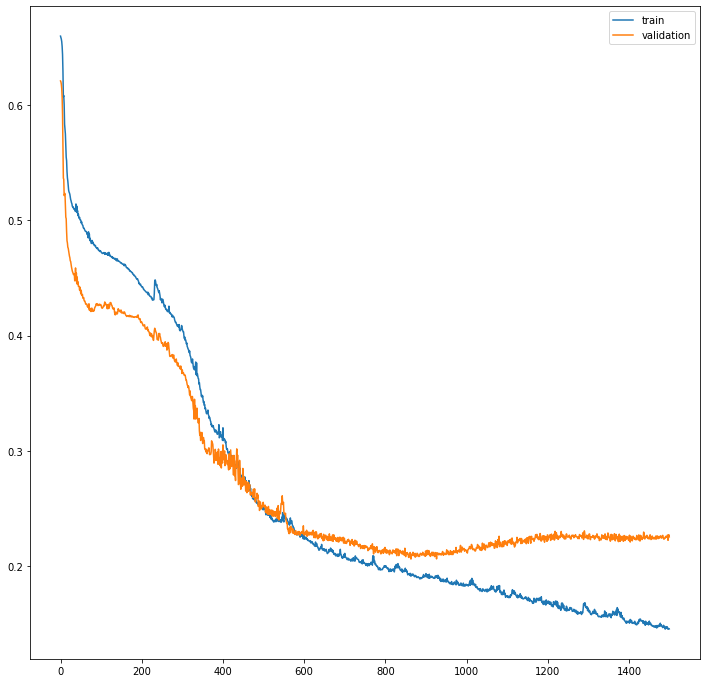

In [12]:
# Training vs. Validation Curve 
plt.figure(figsize=(12,12))
plt.plot(model1.history.__dict__['history']['loss'])
plt.plot(model1.history.__dict__['history']['val_loss'])
plt.legend(['train','validation'])

## Analyze Results 

In [13]:
# Load weights for epoch where training and validation curves intersect
model1.load_weights("weights-improvement-test-500.hdf5")

In [14]:
# Use weights to predict training and testing data 
training_preds = model1.predict(train)
testing_preds = model1.predict(test)

In [15]:
# Find r-vals of actual sequences vs. predicted sequences by trained model for the training and testing data 

r_vals_train = []
for pers_ind, all_preds_pers in enumerate(training_preds):
    person_one = []
    person_one_act = []
    for ind,i in enumerate(all_preds_pers):
        for j in range(3):
            person_one.append(i[j])
            person_one_act.append(train[pers_ind][ind][j])
    r_vals_train.append(stats.pearsonr(person_one, person_one_act)[0])

r_vals_test = [] 
for pers_ind, all_preds_pers in enumerate(testing_preds):
    person_one = []
    person_one_act = []
    for ind,i in enumerate(all_preds_pers):
        for j in range(3):
            person_one.append(i[j])
            person_one_act.append(test[pers_ind][ind][j])
    r_vals_test.append(stats.pearsonr(person_one, person_one_act)[0])
    
print("average of r_vals train: " + str(np.average(r_vals_train)))
print("average of r_vals test: " + str(np.average(r_vals_test)))

average of r_vals train: 0.8186311253031443
average of r_vals test: 0.8319436260691615


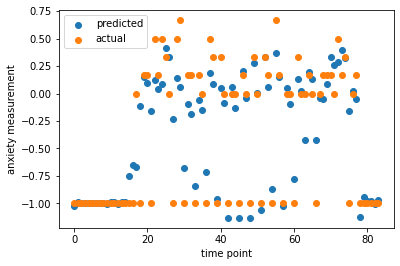

In [16]:
# Demonstrate example of actual vs. predicted sequence for one person-month
person_one = []
person_one_act = []
for ind,i in enumerate(training_preds[4]):
    for j in range(3):
        person_one.append(i[j])
        person_one_act.append(train[4][ind][j])

plt.scatter(list(range(len(person_one))),person_one, label = "predicted")
plt.scatter(list(range(len(person_one))),person_one_act, label = "actual")
plt.xlabel("time point")
plt.ylabel("anxiety measurement")
plt.legend()

Text(0, 0.5, 'actual anxiety')

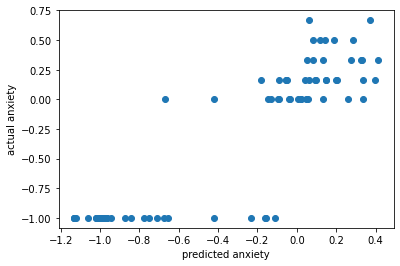

In [17]:
# Demonstrate example of correlation between one's actual and predicted sequences
plt.scatter(person_one,person_one_act)
plt.xlabel("predicted anxiety")
plt.ylabel("actual anxiety")

In [18]:
# Find r-vals for each person-month's actual vs. predicted sequences
all_preds = model1.predict(formatted_data_filtered_nans) # predict on entire data set
r_vals = []
for pers_ind, all_preds_pers in enumerate(all_preds):
    person_one = []
    person_one_act = []
    for ind,i in enumerate(all_preds_pers):
        for j in range(3):
            person_one.append(i[j])
            person_one_act.append(formatted_data_filtered_nans[pers_ind][ind][j])
    r_vals.append(stats.pearsonr(person_one, person_one_act)[0])

In [19]:
# Filter nan r-vals
r_vals_nonan = []
for r in r_vals_train:
    if not math.isnan(r):
        r_vals_nonan.append(r)

<AxesSubplot:ylabel='Density'>

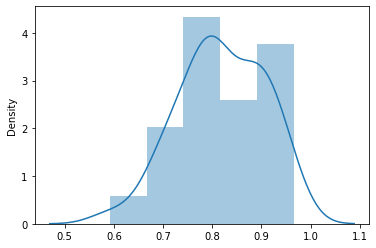

In [20]:
# Plot distribution of r-vals for each all actual vs. predicted sequences for all person-months
sns.distplot(r_vals_nonan)

In [21]:
# Extract feature vector (vector that is output of last encoder layer)
encoder = Model(inputs=model1.inputs, outputs=model1.layers[3].output)
feature_vector = encoder.predict(formatted_data_filtered_nans)
output_feature = feature_vector[:,27,:]
print(output_feature.shape) # output of encoder with 3 nodes 

(66, 3)


In [22]:
# Use 3-layer in analysis 
df = pd.DataFrame(output_feature)
df.to_csv("output_LSTM_3_layer.csv", index=False)